# Income Distribution in Thailand

### Package Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as pe
from sklearn.linear_model import LinearRegression
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
# Visualization Default Settings

params = {"axes.spines.right": False,
          "axes.spines.top": False, 
          "axes.spines.left": False,
          "axes.spines.bottom": False,
          "font.family": "Arial",
          "axes.labelsize": 12,
          "xtick.labelsize": 12,
          "ytick.labelsize": 12
         }
plt.rcParams.update(params)

### Data Import and Preprocessing

In [3]:
raw_data = pd.read_csv('data/TH_TaxIncomeBrackets.csv')
raw_data = raw_data.apply(pd.to_numeric, downcast='float')
raw_data = raw_data.rename(columns={'Tax_Units':'N'})
raw_data['TotIncome'] = raw_data['Tot_Income_mil'] * 1000000
raw_data['AvgIncome'] = raw_data['TotIncome'] / raw_data['N']
raw_data['Income_Mid'] = (raw_data['Income_LB'] + raw_data['Income_UB']) / 2
raw_data = raw_data.sort_values('Income_LB')

* Add Percentile (aka CDF) for both TaxUnits and TotIncome

In [4]:
cum_data = raw_data[['N', 'TotIncome']].cumsum()
cum_data['Income_LB'] = raw_data['Income_LB']
cum_data['CumN'] = cum_data['N'] / np.sum(raw_data['N'])
cum_data['CumIncome'] = cum_data['TotIncome'] / np.sum(raw_data['TotIncome'])
cum_data = cum_data[['Income_LB','CumN','CumIncome']]

* Merging tables and adding previous levels for ease of processing

In [5]:
fin_data = raw_data[['Income_LB', 'Income_Mid', 'Income_UB', 'N', 'TotIncome', 'AvgIncome']].merge(cum_data, how='left', on='Income_LB')
# Add previous values
fin_data = fin_data.assign(CumN_prev = fin_data['CumN'].shift(1, fill_value=0),
                           CumIncome_prev = fin_data['CumIncome'].shift(1, fill_value=0))
# Replace unbounded income bracket upperbound by infinity to prevent accidental mishandling
fin_data.loc[20, 'Income_Mid'] = np.inf
fin_data.loc[20, 'Income_UB'] = np.inf
fin_data

,Income_LB,Income_Mid,Income_UB,N,TotIncome,AvgIncome,CumN,CumIncome,CumN_prev,CumIncome_prev
0,0.00,"50,000.00","100,000.00","1,369,075.00","70,420,000,000.00","51,436.19",0.12,0.01,0.00,0.00
1,"100,000.00","125,000.00","150,000.00","1,163,511.00","146,347,000,000.00","125,780.50",0.23,0.04,0.12,0.01
2,"150,000.00","175,000.00","200,000.00","1,319,399.00","231,703,000,000.00","175,612.53",0.35,0.09,0.23,0.04
3,"200,000.00","250,000.00","300,000.00","2,063,376.00","513,683,000,000.00","248,952.69",0.53,0.19,0.35,0.09
4,"300,000.00","350,000.00","400,000.00","1,447,149.00","505,048,000,000.00","348,995.16",0.66,0.29,0.53,0.19
5,"400,000.00","450,000.00","500,000.00","964,896.00","431,275,000,000.00","446,965.27",0.75,0.38,0.66,0.29
6,"500,000.00","625,000.00","750,000.00","1,355,676.00","822,411,000,000.00","606,642.74",0.87,0.54,0.75,0.38
7,"750,000.00","875,000.00","1,000,000.00","587,572.00","502,278,000,000.00","854,836.51",0.92,0.64,0.87,0.54
8,"1,000,000.00","1,250,000.00","1,500,000.00","438,883.00","529,437,000,000.00","1,206,328.34",0.96,0.74,0.92,0.64
9,"1,500,000.00","1,750,000.00","2,000,000.00","175,204.00","299,431,000,000.00","1,709,042.03",0.98,0.80,0.96,0.74


### Income Distribution

#### Where does the skewness begin?

Within each income bracket, the mean and the midpoint of the bracket would be close to each other if the income is uniformly distributed within that bracket. However, income at a high level normally does not distribute uniformly and usually follows the right-skewed Pareto distribution family. 

By calculating the ratio of mean to midpoint (both offset by the lower bound), we can visually identify the breakpoint where the uniform distribution ends and the long-tailed Pareto distribution begins.

In [6]:
# Last income bracket has no midpoint and has to be excluded.
mid_point = np.array(fin_data['Income_Mid'])[:-1]
avg_inc = np.array(fin_data['AvgIncome'])[:-1]
lb = np.array(fin_data['Income_LB'])[:-1]

# Distance of Mean to Distance of Mid Point from Lower Bound
ratio = (avg_inc - lb) / (mid_point - lb)

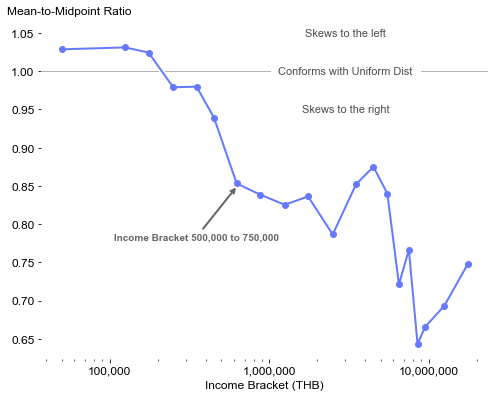

In [7]:
c = '#657aff'

fig, ax = plt.subplots(figsize=(8,6))
ax.axhline(1, color='0.7', linewidth=1)
ax.plot(mid_point, ratio, color=c, linewidth=2, path_effects=[pe.Stroke(linewidth=5, foreground='w'), pe.Normal()])
ax.plot(mid_point, ratio, 'o', color=c)

ax.annotate(" Conforms with Uniform Dist ", (3000000, 1.00), fontsize=11, color='0.3', ha='center', va='center', bbox={'facecolor':'w', 'edgecolor':'w'})
ax.annotate("Skews to the left", (3000000, 1.05), fontsize=11, color='0.3', ha='center', va='center')
ax.annotate("Skews to the right", (3000000, 0.95), fontsize=11, color='0.3', ha='center', va='center')

ax.annotate("Income Bracket 500,000 to 750,000", xy=(630000, 0.85), xytext=(350000, 0.78), 
            ha='center', color='0.4', weight='bold',
            arrowprops={"arrowstyle":"->", "color":'0.4', "linewidth":2}
           )

ax.set_xscale('log')
ax.set_xticks([100000, 1000000, 10000000])
ax.set_xticklabels(['100,000', '1,000,000', '10,000,000'])


ax.set_xlabel('Income Bracket (THB)')
ax.set_ylabel('Mean-to-Midpoint Ratio', rotation=0, ha='left', position=(0,1.05))

#plt.title("Uniform Distribution doesn't fit well from Income Bracket of 500,000 onwards", fontsize=16, y=1.12)

plt.show()
fig.savefig('output/skewness.jpg', bbox_inches='tight', dpi=300)

The skewness appears to begin at the income bracket [500k, 750k].

We therefore select 500,000 as the threshold.

In [8]:
pareto_threshold = 500000
high_income_data = fin_data.query('Income_LB >= @pareto_threshold')
low_income_data = fin_data.query('Income_LB < @pareto_threshold')

#### Fitting Pareto Distribution

Since the CDF or $F(x)$ of a Pareto distribution is $1 - \bigg(\frac{x_m}{x}\bigg)^\alpha$, it follows that,

$\log(1 - F(x)) = \log(S(x)) = \alpha \log(x_m) - \alpha \log(x) = a \log(x) + b$

The alpha can then be estimated from the slope of the linear regression of $\log(S(X))$ against $\log(X)$

In [9]:
S = np.array(1.00 - high_income_data['CumN'])[:-1]  # Remove the unbounded bracket (last row) since LOG(0) is undefined.
logS = np.log(S)
logX = np.log(np.array(high_income_data['AvgIncome']))[:-1]

reg = LinearRegression(fit_intercept=True).fit(logX.reshape(-1,1), logS)
alpha = -reg.coef_[0]
print('The estimate of alpha is %.4f' % alpha)

The estimate of alpha is 1.8341


In [10]:
# Prepare the fitted lines data
fit_X = np.linspace(np.min(logX)*0.995, np.max(logX)*1.005, 100)
fit_Y = reg.predict(fit_X.reshape(-1,1))

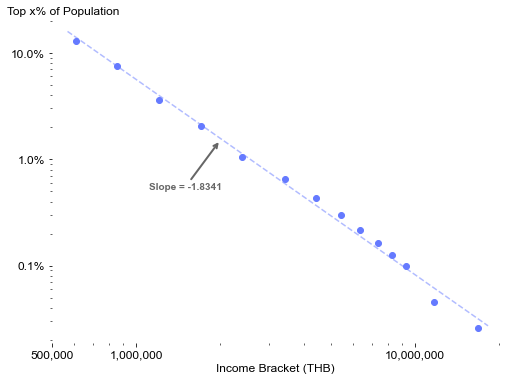

In [11]:
c = '#657aff'

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(high_income_data['AvgIncome'], 1-high_income_data['CumN'], 'o', color=c)
ax.plot(np.exp(fit_X), np.exp(fit_Y), color=c, linestyle='--', alpha=0.5)

ax.annotate("Slope = -1.8341", xy=(2000000, 0.015), xytext=(1500000, 0.006), 
            ha='center',va='top', color='0.4', weight='bold',
            arrowprops={"arrowstyle":"->", "color":'0.4', "linewidth":2}
           )


ax.set_xscale('log')
ax.set_xticks([500000, 1000000, 10000000])
ax.set_xticklabels(['500,000', '1,000,000', '10,000,000'])
ax.set_xlim((500000, 20000000))


ax.set_yscale('log')

ax.set_xlabel('Income Bracket (THB)')
ax.set_ylabel('Top x% of Population', rotation=0, ha='left', position=(0,1))

ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

plt.show()
fig.savefig('output/pareto_alpha.jpg', bbox_inches='tight', dpi=300)

* Sense Check

Visually, the distribution appears to fit the data well. As a sense check, we will also compare the fitted mean against the sample mean.

Expected value of a Pareto distribution with support from $[x_m, \infty)$ is $\displaystyle \frac{\alpha x_m}{\alpha-1}$. Here $x_m$ is chosen to be 500,000.

The fitted mean is

In [12]:
print('%i' %(alpha / (alpha - 1) * pareto_threshold))

1099420


The sample mean is

In [13]:
print('%i' % int(np.sum(high_income_data['TotIncome']) / np.sum(high_income_data['N'])))

1132048


If we exclude the last income bracket, the sample mean is

In [14]:
print('%i' % int(np.sum(np.array(high_income_data['TotIncome'])[:-1]) / np.sum(np.array(high_income_data['N'])[:-1])))

1088572


The discrepancy is assumed to be within the acceptable degree of accuracy.

#### Upper Bound of Distribution

Support of a Pareto distribution is unbounded; however, in reality, there must be an upper bound to the annual income.

Based on the population size,

```np.sum(fin_data['N']) = 11112910```

the highest income earner would be placed at percentile $99.999991$th $(= 1 - 1 / 11112910)$

Based on the fitted Pareto distribution, this would correspond to income $x_u$ which satisfies:

$F(500000) + (1 - F(500000))(1 - (500000 / x_u)^\alpha) = (1 - 1 / N)$

This works out to be $x_u =$ 1,632,408,146 or about 1.6 billion THB annually or 135 million THB monthly.

Code: ```np.exp(np.log(pareto_threshold) - np.log(1-(1-1/np.sum(fin_data['N']) - border_CDF)/(1-border_CDF))/alpha)``` where border_CDF represents F(500000)

By the same logic, the second highest earner is estimated to have an annual income of 1,118,671,717.

In order to avoid false precision, income above 1.2 billion will be capped.

## Defining Full Distribution

### Income Distribution

* **Percentiles and Income Shares of income below 500,000** are estimated based on the empirical distribution assuming uniform distribution within each bracket. Based on this, percentile can be estimated by linear interpolation but not the income share, which we must use conditional expectation to calculate (see the Section below).

* **Percentiles and Income Shares of income above 500,000** are estimated using the Pareto distribution. Both the percentile and income share can be algebraically solved and have closed-form solutions. As an implication, the estimated percentile and income share at the income brackets’ boundaries do not exactly match the empirical distribution; however, the discrepancy is not material.


In [15]:
border_CDF = np.array(high_income_data['CumN_prev'])[0]  # F(500,000)
upper_cap = 1200000000

def findPercentile(annual):
    # Corner Cases
    if annual <= 0:
        return 0
    elif annual >= pareto_threshold:
        # Apply Pareto Distribution
        if annual > upper_cap:
            annual == upper_cap
        return border_CDF + (1 - border_CDF) * (1 - (pareto_threshold / annual) ** alpha)
    else:
        # Linear Interpolation within the corresponding Income Bracket
        return linearInt(annual)
    
def linearInt(annual):
    filter_data = low_income_data.query('Income_LB < @annual & Income_UB >= @annual').to_dict('list')
    lb = filter_data['Income_LB'][0]
    ub = filter_data['Income_UB'][0]
    lb_cdf = filter_data['CumN_prev'][0]
    ub_cdf = filter_data['CumN'][0]
    return lb_cdf + (annual - lb) / (ub - lb) * (ub_cdf - lb_cdf)

In [16]:
# Calculate the CDF for the whole range of income
income_range = np.logspace(3, 9.08, 1000)
income_CDF = np.array([findPercentile(income) for income in income_range])

### Income Share Calculation

* For annual income below the Pareto threshold

Given income $x$ which falls within the bracket $[x_l, x_u]$ with corresponding CDF of $[F(x_l), F(x_u)]$ and corresponding empirical income share of $[\pi_l, \pi_u]$, assuming uniform distribution, share of total income for people who earn $x$ or less is:

$\displaystyle \pi_l + \frac{E[X \le x|x_l \le X \le x_u]}{E[X|x_l \le X \le x_u]}(\pi_u - \pi_l)$

Which is equal to:

$\displaystyle \pi_l + \frac{(F(x) - F(x_l))(x + x_l)}{(F(x_u) - F(x_l))(x_u + x_l)}(\pi_u - \pi_l)$

* For annual income above the Pareto threshold

Using the property that conditional mean of Pareto distribution above a new threshold $x_n > x_m$ is $\displaystyle \frac{\alpha x_n}{\alpha-1}$, the share of income to people who earn $x_n$ or less when $x_n > x_m = 500000$ is:

$\displaystyle \pi_{x_m} + (1 - \pi_{x_m})\Bigg[1 - \frac{E[X \ge x_n | X \ge x_m]}{E[X | X \ge x_m]}\Bigg] = 
\pi_{x_m} + (1 - \pi_{x_m})\Bigg[1-\Bigg(\frac{x_m}{x_n}\Bigg)^{\alpha - 1}\Bigg]$

Since $E[X \ge x_n | X \ge x_m] = E[X \ge x_n | X \ge x_n]\Pr(X \ge x_n | X \ge x_m)$, for a Pareto distribution, this becomes $\displaystyle \frac{\alpha x_n}{\alpha-1} \Bigg(\frac{x_m}{x_n}\Bigg)^\alpha$.

In [17]:
border_IncShare = np.array(high_income_data['CumIncome_prev'])[0]  # F(500,000)

def findIncomeShareBelow(annual):
    if annual <= 0:
        return 0
    elif annual >= pareto_threshold:
        return border_IncShare + (1 - border_IncShare) * (1 - (pareto_threshold / annual)**(alpha - 1))
    else:
        return linearIncShare(annual)

def linearIncShare(annual):
    filter_data = low_income_data.query('Income_LB < @annual & Income_UB >= @annual').to_dict('list')
    lb = filter_data['Income_LB'][0]
    ub = filter_data['Income_UB'][0]
    lb_cdf = filter_data['CumN_prev'][0]
    ub_cdf = filter_data['CumN'][0]
    lb_share = filter_data['CumIncome_prev'][0]
    ub_share = filter_data['CumIncome'][0]
    
    return lb_share + (linearInt(annual) - lb_cdf) * (annual + lb) * (ub_share - lb_share) / ((ub_cdf - lb_cdf) * (lb + ub))

In [18]:
# Calculate the Income Share for the previously established range
income_shareBelow = np.array([findIncomeShareBelow(income) for income in income_range])

## Main Figures - Visualization

### Income Percentile (CDF)

Note:

25th percentile = 159,310

50th percentile = 282,610

75th percentile = 500,720

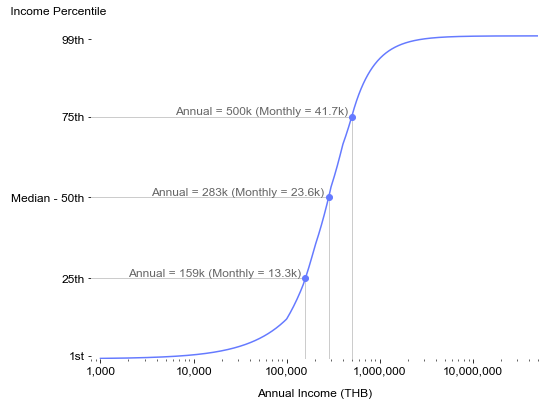

In [19]:
highlights = [(159310, 0.25, 'Annual = 159k (Monthly = 13.3k)'), 
              (282610, 0.50, 'Annual = 283k (Monthly = 23.6k)'), 
              (500720, 0.75, 'Annual = 500k (Monthly = 41.7k)')]

c = '#657aff'

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(income_range, income_CDF, color=c)
ax.set_xscale('log')
ax.set_yscale('linear')
ax.set_xticks([1000, 10000, 100000, 1000000, 10000000])
ax.set_xticklabels(['1,000', '10,000', '100,000', '1,000,000', '10,000,000'])
ax.set_yticks([0.01, 0.25, 0.5, 0.75, 0.99])
ax.set_yticklabels(['1st','25th','Median - 50th', '75th', '99th'])

ax.set_xlim((800, 50000000))
ax.set_ylim((0, 1.01))
ax.set_xlabel('Annual Income (THB)', labelpad=12)
ax.set_ylabel(' Income Percentile', rotation=0, ha='left', position=(0,1.05))

for (x,y,t) in highlights:
    ax.plot([0, x], [y, y], '0.8', lw=1)
    ax.plot([x, x], [0, y], '0.8', lw=1)
    ax.plot([x],[y],'o',color=c)
    ax.annotate(t, xy=(x,y), xycoords='data', 
                xytext=(-4,0), textcoords='offset points', 
                color='0.4', ha='right', va='bottom', fontsize=12)

#plt.title('Income Distribution in Thailand', fontsize=16, y=1.1)
plt.show()

fig.savefig('output/CDF.jpg', bbox_inches='tight', dpi=300)

## Lorenz Curve - Income Inequality

Lorenz Curve is a graph showing the proportion of overall income or wealth assumed by the bottom x% of the population.

As a sense check, we will first confirm that the fitted curve is in line with the empirical curve.

In [20]:
lorenz_x = np.append([0],fin_data['CumN'])
lorenz_y = np.append([0],fin_data['CumIncome'])

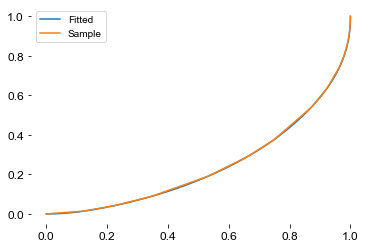

In [21]:
fig, ax = plt.subplots()
ax.plot(income_CDF, income_shareBelow, label='Fitted')
ax.plot(lorenz_x, lorenz_y, label='Sample')
ax.legend()
plt.show()

It appears that the fitted curve is in line with the empirical curve. We will then rely on the fitted curve.

* Calculation of Gini

This calculation assumes a linear interpolation between observed values. 
Due to the convex nature of Lorenz curve, the Gini coefficient calculated using a smooth curve would result in a higher Gini estimate.
Therefore, it's better to use the fitted curve than the empirical curve.

In [22]:
gini = 0
for i in range(len(income_CDF) - 1):
    gini += ((income_CDF[i+1] - income_shareBelow[i+1]) + (income_CDF[i] - income_shareBelow[i])) * (income_CDF[i+1] - income_CDF[i])
print('Estimated Gini Coefficient: %.4f' % gini)

Estimated Gini Coefficient: 0.5213


* Visualization

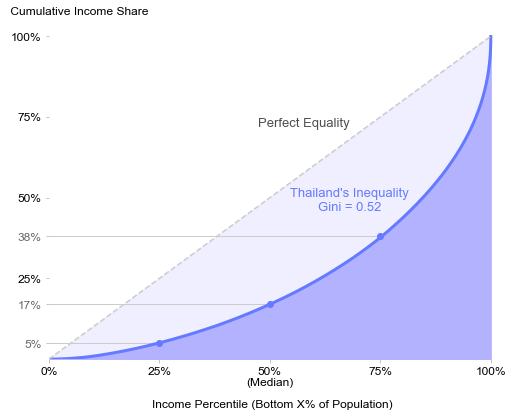

In [23]:
highlights = [(0.25, 0.05), (0.50, 0.17), (0.75, 0.38)]

c = '#657aff'
c_light = '#e0e0ff'
c_dark = '#b2b2ff'

fig, ax = plt.subplots(figsize=(8,6))

for (x,y) in highlights:
    ax.plot([0, x], [y, y], '0.8', lw=1)
    ax.plot([x],[y],'o', color=c)

ax.plot(income_CDF, income_shareBelow, color=c, linewidth=3)
ax.plot([0,1],[0,1],'0.8',linestyle='--')

ax.set_axisbelow(True)
#ax.grid(axis='y')
ax.tick_params(axis='both', color='0.7')


ax.fill_between(income_CDF, income_shareBelow, income_CDF, where=(income_CDF >= income_shareBelow), color=c_light, alpha=0.5)
ax.fill_between(income_CDF, income_shareBelow, 0, where=(income_shareBelow >= 0), color=c_dark)
ax.set_xlabel('Income Percentile (Bottom X% of Population)', labelpad=12)
ax.set_ylabel(' Cumulative Income Share', rotation=0, ha='left', position=(0,1.05))

ax.set_xticks([0.00, 0.25, 0.50, 0.75, 1.00])
ax.set_xticklabels(['0%', '25%', '50%\n(Median)', '75%', '100%'])
ax.set_yticks([0.05, 0.17, 0.25, 0.38, 0.5, 0.75, 1.00])
ax.get_yticklabels()[0].set_color('0.4')
ax.get_yticklabels()[1].set_color('0.4')
ax.get_yticklabels()[3].set_color('0.4')

ax.set_xlim((0,1.01))
ax.set_ylim((0,1.01))


#ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

ax.annotate('Perfect Equality', (0.68, 0.72), color='0.3', ha='right', fontsize=13)
ax.annotate("Thailand's Inequality\nGini = %.2f" % gini, (0.68, 0.46), color=c, ha='center', fontsize=13)

#plt.title('Bottom half of Thai population receive less than 20% of Total Income\nwhile the top 10% receive more than 40% of Total Income', fontsize=16, y=1.1)
plt.show()

fig.savefig('output/lorenz.jpg', bbox_inches='tight', dpi=300)